# Abstract

**Author:** [Charles Tapley Hoyt](https://github.com/cthoyt)

**Estimated Run Time:** 2 minutes

This notebook demonstrates the ease with which [PyBEL](http://pybel.readthedocs.io) can be used to parse BEL scripts and work with other formats for biological knowledge assembly models. It further demonstrates how its sister package, [PyBEL Tools](http://pybel-tools.readthedocs.io) can be used to visualize and explore the Alzheimer's Disease (AD) knowledge assembly model that has been annotated with the [NeuromMMSig Database](http://neurommsig.scai.fraunhofer.de/pathways/introduction) to gain further mechanistic insight.

### Notebook Imports

In [ ]:
import logging
import os
import sys
import time
from collections import Counter, defaultdict
from operator import itemgetter

import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import scipy.cluster.hierarchy as sch
from IPython.display import IFrame
from matplotlib_venn import venn2

import pybel
import pybel_tools as pbt
from pybel.constants import *
from pybel_tools.visualization import to_jupyter
from pybel_tools.utils import barh, barv

In [1]:
%config InlineBackend.figure_format = 'svg'
%matplotlib inline

In [2]:
logging.basicConfig(level=20)

### Notebook Constants

The width and height of visualizations are kepy constant throughout this notebook.

In [3]:
graph_vis_width = 1000
graph_vis_height = 650

### Notebook Provenance

The time of execution and the versions of the software packegs used are displayed explicitly.

In [4]:
time.asctime()

'Wed Mar 15 11:50:10 2017'

In [5]:
pybel.__version__

'0.4.1'

In [6]:
pbt.__version__

'0.1.3-dev'

### Local Path Definitions

To make this notebook interoperable across many machines, locations to the repositories that contain the data used in this notebook are referenced from the environment, set in `~/.bashrc` to point to the place where the repositories have been cloned. Assuming the repositories have been `git clone`'d into the `~/dev` folder, the entries in `~/.bashrc` should look like:

```bash
...
export BMS_BASE=~/dev/bms
export BANANA_BASE=~/dev/banana
...
```

#### BMS 

The biological model store (BMS) is the internal Fraunhofer SCAI repository for keeping BEL models under version control. It can be downloaded from https://tor-2.scai.fraunhofer.de/gf/project/bms/

In [7]:
bms_base = os.environ['BMS_BASE']

#### BANANA

Project BANANA contains data sets and analytical pipelines from the NeuroAllianz and D10 projects intended for algorithm development. It can be downloaded from https://tor-2.scai.fraunhofer.de/gf/project/banana

In [8]:
banana_base = os.environ['BANANA_BASE']

# Alzheimer's Disease Knowledge Assembly

## Loading

The Alzheimer's Disease Knowledge Assembly has been precompiled with the following command line script, and will be loaded from this format for improved performance. In general, derived data, such as the gpickle representation of a BEL script, are not saved under version control to ensure that the most up-to-date data is always used.

```sh
pybel convert --path "$BMS_BASE/aetionomy/alzheimers.bel" --pickle "$BMS_BASE/aetionomy/alzheimers.gpickle"
```

The BEL script can also be compiled from inside this notebook with the following python code:

```python
>>> import os
>>> import pybel
>>> # Input from BEL script
>>> bel_path = os.path.join(bms_base, 'aetionomy', 'alzheimers.bel')
>>> graph = pybel.from_path(bel_path)
>>> # Output to gpickle for fast loading later
>>> pickle_path = os.path.join(bms_base, 'aetionomy', 'alzheimers.gpickle')
>>> pybel.to_pickle(graph, pickle_path)
```

In [9]:
pickle_path = os.path.join(bms_base, 'aetionomy', 'alzheimers.gpickle')

In [10]:
graph = pybel.from_pickle(pickle_path, check_version=False)

## Summary

A summary of the types of nodes and edges is output using `matplotlib` and [pbt.summary.plot_summary](http://pybel-tools.readthedocs.io/en/latest/summary.html#pybel_tools.summary.plot_summary). It is displayed with beautiful vector graphics using a tweak at the beginning of the notebook: `%config InlineBackend.figure_format = 'svg'` 

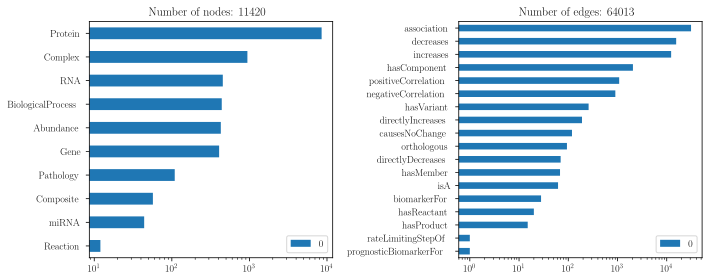

In [11]:
pbt.summary.plot_summary(graph, plt, figsize=(10, 4))
plt.show()

A summary of the namespaces used in the network can provide insight to the types of articles used. For example, it's good to know that a graph consists of many nodes from literature on Human, Mouse, and Rat. This can be produced with [pbt.summary.count_namespaces](http://pybel-tools.readthedocs.io/en/latest/summary.html#pybel_tools.summary.count_namespaces) and plotted with `matplotlib`. PyBEL Tools also provides a wrapper for plotting the `Counter` objects returned by many of its functions with [pbt.utils.barh](http://pybel-tools.readthedocs.io/en/latest/utilities.html#pybel_tools.utils.barh) and [pbt.utils.barv](http://pybel-tools.readthedocs.io/en/latest/utilities.html#pybel_tools.utils.barv).


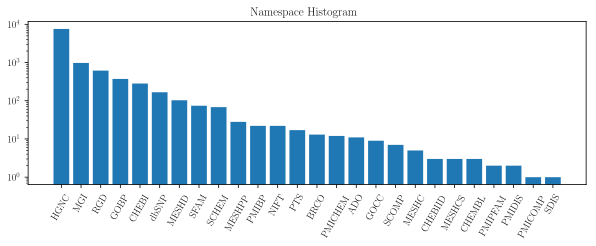

In [12]:
namespace_counter = pbt.summary.count_namespaces(graph)

plt.figure(figsize=(10, 3))
barv(namespace_counter, plt, 'Namespace Histogram', rotation=60)
plt.yscale('log')

Immediately, the MGI and RGD nodes should be discarded using the in-place mutation function [pbt.mutation.remove_nodes_by_namespace](http://pybel-tools.readthedocs.io/en/latest/mutation.html#pybel_tools.mutation.remove_nodes_by_namespace).

In [13]:
pbt.mutation.remove_nodes_by_namespace(graph, GENE, 'MGI')
pbt.mutation.remove_nodes_by_namespace(graph, RNA, 'MGI')
pbt.mutation.remove_nodes_by_namespace(graph, PROTEIN, 'MGI')

pbt.mutation.remove_nodes_by_namespace(graph, GENE, 'RGD')
pbt.mutation.remove_nodes_by_namespace(graph, RNA, 'RGD')
pbt.mutation.remove_nodes_by_namespace(graph, PROTEIN, 'RGD')

Likewise, a histogram of the usage of annotations in the network calculated with [pbt.summary.count_annotations](http://pybel-tools.readthedocs.io/en/latest/summary.html#pybel_tools.summary.count_annotations) can quickly summarize the information content contained within the graph.

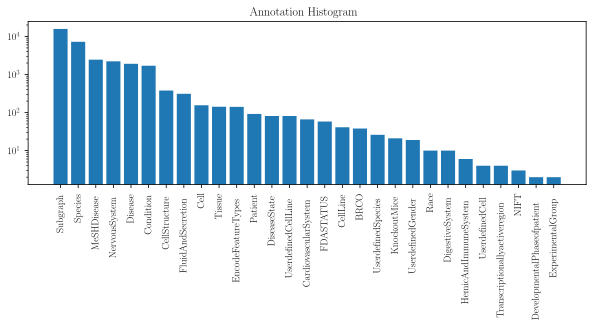

In [14]:
annotation_counter = pbt.summary.count_annotations(graph)

# Problem with encoding underscores in latex. Disregard this
annotation_counter = {k.replace('_', ''): v for k, v in annotation_counter.items()}

plt.figure(figsize=(10, 3))
barv(annotation_counter, plt, 'Annotation Histogram')
plt.yscale('log')

The NeuroMMSig Database, the largest mechanism inventory related to Alzheimer's and Parkinson's Disease, has been pre-annotated to the knowledge assembly. Many functions have been written to extract information about the logical subgraphs underlying these mechanisms.

The function [pbt.summary.count_annotation_values](http://pybel-tools.readthedocs.io/en/latest/summary.html#pybel_tools.summary.count_annotation_values) is used to count the number of edges in each Subgraph. Below is output the total number of unique Subgraphs:

In [15]:
subgraph_counter = pbt.summary.count_annotation_values(graph, 'Subgraph')

len(subgraph_counter)

126

The counts are examined closer by outputting the top 30 biggest subgraphs with their sizes as a bar plot.

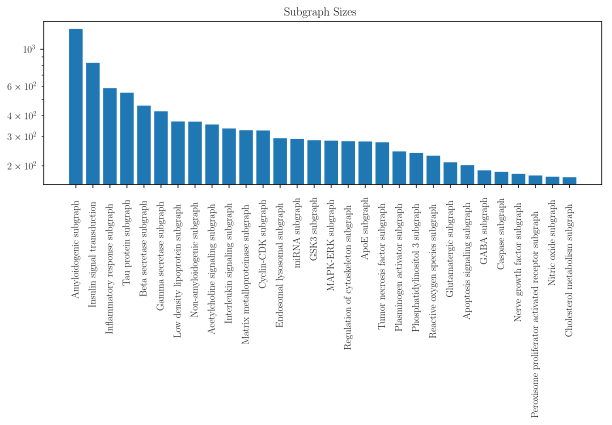

In [16]:
top_subgraph_counter = dict(subgraph_counter.most_common(30))

plt.figure(figsize=(10, 3))
barv(top_subgraph_counter, plt, 'Subgraph Sizes')
plt.yscale('log')

A subgraph can be easily selected with [pbt.selection.get_subgraph_by_annotation](http://pybel-tools.readthedocs.io/en/latest/selection.html#pybel_tools.selection.get_subgraph_by_annotation). In this example, the GABA subgraph is used. A simple summary of the subgraph can be printed with [pbt.summary.print_summary](http://pybel-tools.readthedocs.io/en/latest/summary.html#pybel_tools.summary.print_summary)

In [17]:
example_subgraph_name = 'GABA subgraph'

subgraph = pbt.selection.get_subgraph_by_annotation(graph, annotation='Subgraph', value=example_subgraph_name)

pbt.summary.print_summary(subgraph)

Name: Alzheimer's Disease Model - Subgraph - GABA subgraph
Number of nodes: 67
Number of edges: 188
Network density: 0.04251469923111714
Number weakly connected components: 6
Average in-degree: 2.8059701492537314
Average out-degree: 2.8059701492537314


The best way to explore a subgraph is when displayed as a subgraph. A module for outputting an interactive visualization directly in a Jupyter Notebook is built in to [pbt.visualization.to_jupyter](http://pybel-tools.readthedocs.io/en/latest/visualization.html#pybel_tools.visualization.to_jupyter)

In [18]:
to_jupyter(subgraph)

<IPython.core.display.Javascript object>

The fact that a subgraph contains more than one connected component probably means that there were errors in the original BEL script. There is an entire module devoted to analyzing the errors produced during compilation called `pbt.summary.error_summary`

However, it's also possible that the connections are due to lack of knowledge in the literature. In the curation process for the NeuroMMSig Database, many entitity types were not considered. We've developed an algorithm for inferring additional members of a subgraph, including chemicals that occur as intermediates in biochemical processes, and higher level entities such as biological processes. The set of tools for running the algorithm are avaliable in the `pbt.mutations.subgraph_expansion` submodule (see [pbt.mutation.fill_subgraph](http://pybel-tools.readthedocs.io/en/latest/mutation.html#pybel_tools.mutation.fill_subgraph)). 

In this example, the inferred edges are limited to only causal edges, to avoid adding many low confidence relations.

In [19]:
node_count_before, edge_count_before = subgraph.number_of_nodes(), subgraph.number_of_edges()    
pbt.mutation.fill_subgraph(graph, subgraph, threshold=5, edge_filters=pbt.filters.keep_causal_edges)

node_change = subgraph.number_of_edges() - node_count_before
edge_change = subgraph.number_of_edges() - edge_count_before

print('Adding {} nodes and {} edges'.format(node_change, edge_change))
pbt.summary.print_summary(subgraph)

Adding 3621 nodes and 3500 edges
Name: Alzheimer's Disease Model - Subgraph - GABA subgraph
Number of nodes: 519
Number of edges: 3688
Network density: 0.013718094642950134
Number weakly connected components: 2
Average in-degree: 7.105973025048169
Average out-degree: 7.105973025048169


Before making a visualization, we can use prior knowledge that some nodes are huge hubs and aren't meaningful to the process. Producing filter functions can be done with the `pbt.filters` submodule using ideas and styles from functional programming. This example uses [pbt.mutation.remove_filtered_nodes](http://pybel-tools.readthedocs.io/en/latest/mutation.html#pybel_tools.mutation.remove_filtered_nodes) to identify and remove all nodes whose data dictionaries contain `PATHOLOGY` as the value for their `FUNCTION`.

In [20]:
# remove pathologies
pbt.mutation.remove_filtered_nodes(subgraph, lambda graph, node: PATHOLOGY == graph.node[node][FUNCTION])

# remove other nodes
subgraph.remove_node((ABUNDANCE, 'CHEBI', 'estradiol'))
subgraph.remove_node((ABUNDANCE, 'CHEBI', 'copper sulphate(5.H2O)'))

# remove anything floating alone
subgraph.remove_nodes_from(nx.isolates(subgraph))

In [21]:
pbt.summary.print_summary(subgraph)

Name: Alzheimer's Disease Model - Subgraph - GABA subgraph
Number of nodes: 263
Number of edges: 1899
Network density: 0.027559283661800132
Number weakly connected components: 2
Average in-degree: 7.220532319391635
Average out-degree: 7.220532319391635


In [22]:
to_jupyter(subgraph)

<IPython.core.display.Javascript object>

This subgraph has become very complicated and contains many edges that aren't interesting - we would like to examine only the causal edges. These can be extracted with [pbt.selection.get_causal_subgraph](http://pybel-tools.readthedocs.io/en/latest/selection.html#pybel_tools.selection.get_causal_subgraph).

In [23]:
subgraph = pbt.selection.get_causal_subgraph(subgraph)

pbt.summary.print_summary(subgraph)

Name: 
Number of nodes: 260
Number of edges: 1817
Network density: 0.026982476982476983
Number weakly connected components: 2
Average in-degree: 6.9884615384615385
Average out-degree: 6.9884615384615385


Practically, this didn't remove many edges and will not help for visualzation purposes. This subgraph is very complicated and contains many nodes across the central dogma - genes, RNA, miRNA, and proteins. In some cases, a gene and its corresponding protein may not be connected with the intermediate RNA. This can be filled in with [pbt.mutation.infer_central_dogma](http://pybel-tools.readthedocs.io/en/latest/mutation.html#pybel_tools.mutation.infer_central_dogma).

Sometimes, it is easier to work with graphs that have the seperate nodes representing each of these entities combine and represented by the corresponding gene. This transformation can be accomplished with [pbt.mutation.opening_by_central_dogma_to_genes](http://pybel-tools.readthedocs.io/en/latest/mutation.html#pybel_tools.mutation.opening_by_central_dogma).

In [24]:
# Warning - this operation is in-place
pbt.mutation.opening_by_central_dogma_to_genes(subgraph)

pbt.summary.print_summary(subgraph)

Name: 
Number of nodes: 254
Number of edges: 1811
Network density: 0.02818150695589929
Number weakly connected components: 2
Average in-degree: 7.1299212598425195
Average out-degree: 7.1299212598425195


In [25]:
to_jupyter(subgraph)

<IPython.core.display.Javascript object>

In [26]:
# remove pathologies
pbt.mutation.remove_filtered_nodes(subgraph, lambda graph, node: PATHOLOGY == graph.node[node][FUNCTION])

# Remove isolated nodes
subgraph.remove_nodes_from(list(nx.isolates(subgraph)))

pbt.summary.print_summary(subgraph)

Name: 
Number of nodes: 254
Number of edges: 1811
Network density: 0.02818150695589929
Number weakly connected components: 2
Average in-degree: 7.1299212598425195
Average out-degree: 7.1299212598425195


In [27]:
to_jupyter(subgraph)

<IPython.core.display.Javascript object>

Further investigation can be done on the graph by prioritizing nodes by betweenness centrality. The top 25 most central nodes are selected.

In [28]:
node_centrality = nx.betweenness_centrality(subgraph, normalized=True)

nodes = sorted(node_centrality.items(), key=itemgetter(1), reverse=True)

for node, centrality in nodes[:25]:
    print('{:60} {}'.format(str(node), centrality))

('Protein', 'HGNC', 'APP', ('frag', (672, 713)))             0.22944930585014298
('Gene', 'HGNC', 'TNF')                                      0.07963858558155565
('Gene', 'HGNC', 'APP')                                      0.05713734661736801
('BiologicalProcess', 'GOBP', 'calcium ion import')          0.01865077911844444
('Abundance', 'CHEBI', 'nitric oxide')                       0.015614818743935988
('Gene', 'HGNC', 'NFKB1')                                    0.015518258780069436
('BiologicalProcess', 'GOBP', 'inflammatory response')       0.012597507162724555
('Abundance', 'BRCO', 'Microglia')                           0.01222630026977853
('Gene', 'HGNC', 'IFNG')                                     0.01222630026977853
('Gene', 'HGNC', 'PSEN2')                                    0.010276992179871935
('Gene', 'HGNC', 'ACHE')                                     0.009172619421066626
('Abundance', 'CHEBI', 'galanthamine')                       0.008658008658008656
('Gene', 'HGNC', 'ADAM

The subgraphs are analyzed for overlap by their shared nodes with [pbt.summary.summarize_subgraph_node_overlap](http://pybel-tools.readthedocs.io/en/latest/summary.html#pybel_tools.summary.summarize_subgraph_node_overlap). Ultimately, there isn't a huge overlap by node definitions. By using the expansion workflow from before, subgraph distances can be more readily calculated.

In [29]:
overlap_data = pbt.summary.summarize_subgraph_node_overlap(graph)
distance_data = 1 - overlap_data

Y = sch.linkage(distance_data, method='centroid')
Z = sch.dendrogram(Y, no_plot=True)

# axdendro.set_xticks([])
# axdendro.set_yticks([])
# axmatrix = fig.add_axes([0.3,0.1,0.6,0.8])

index = Z['leaves']

# D = D[index,:]
# D = D[:,index]

l = [overlap_data.columns[i] for i in index]
overlap_data[overlap_data > .99] = 0

plt.pcolormesh(overlap_data.loc[l, l], cmap='afmhot')
plt.show()

/usr/local/lib/python3.6/site-packages/ipykernel/__main__.py:4: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix


# Conclusions

PyBEL and PyBEL Tools have a wide range of functions and workflows for analyzing. While PyBEL is itself an incredibly complicated package, its user interface is very simple and straightforwards. PyBEL Tools contains other modules for analyzing the errors in a BEL script, for integrating orthology and equivalence information, and for evaluating the correctness of a network based on a "biological grammar"

See the documentation at https://pybel.readthedocs.io and https://pybel-tools.readthedocs.io for more, specific examples.